In [1]:
import os
import sys
import numpy as np
import os.path as pa
from astropy.table import Table
from scipy.interpolate import interp1d
from snlstm.SpecProc import HomogenizeSpec
from snlstm.Predict import SNLSTM_Predict

import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import tensorflow
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)
from tensorflow.keras.models import load_model

#R_PATH = '/path/to/your/R-programming'
PATH_R = '/usr/bin/R'         # FIXME
assert pa.exists(PATH_R)

#SNDir = '/path/to/your/directory/of/sn2016coj'
SNDir = '/home/thomas/Lpackages/snlstm-extra/sn2016coj'
assert pa.exists(SNDir)

#MODEL_PATH = '/path/to/the/lstm/model'  # Note: the default model file BiLSTM4ST.h5 can be found on Github
MODEL_PATH = '/home/thomas/Lpackages/snlstm-extra/BiLSTM4ST.h5'
assert pa.exists(MODEL_PATH)


### Make Spectral Prediction from one spectrum of SN 2016coj
- SN 2016coj is a well-observed SN Ia in the latest BSNIP data release (Bibcode: 2020MNRAS.492.4325S).
- No spectroscopic data was included in our archival dataset, namely, it is a new SN for our predictive model.

#### Additional Remarks:
- Here the default lstm model was trained on 90% spectra of our archival data set CSD (Note that SN 2016coj is not included in CSD).
    - For well-observed SN such as SN 2016coj, one may expect to get a higher quality spectral predictions if we re-train a new model with the additional samples from SN 2016coj itself. However, In this case, our aim is just to demonstrate the predictive performance (of the default model) from a single spectrum around maximum of a typical SN Ia.
    - one want to know how to train a new model from a given training dataset, please see the module snlstm.Train.SNLSTM_Train.
##### &emsp;
- If the overall spectral color is significally deviated from the corresponding photometric color, such inconsistency can degrade the lstm predictions. 
    - The problem is mainly due to the technical difficulties in spectrophotometry and can be conspicuous in many spectra observed at the same phases by diﬀerent telescopes. To surpress the inconsistency in our CSD dataset, we used a simple color calibration process to align synthetic B-V magnitude measured from a spectrum to corresponding photometric magnitude.
    - In practice, our oversimplified calibration is very useful when the color deviation for an individual SN is quite significant. We also found it critical for building a training spectral dataset (downloaded from heterogeneous sources) to have continuous color evolution for each trained SN. One can check another notebook '3-SpecData_Process_Example.ipynb' to learn how the calibration works.  
    - However, we may skip the color calibration process when the spectroscopic observations are already well calibrated or a simple calibration cannot guarantee to push the spectrum towards its true color. (in this example, all the spectra of SN 2016coj were observed by the same instrument and we skipped the color calibration.)
    - Users may be able to perform color calibration with higher accuracy by their own methods, e.g., using multiband photometry color more than B-V.
##### &emsp;

In [2]:
# ** Basic information abour SN 2016coj
redshift = 0.0045     # redshift of SN 2016coj
MJD_Bmax = 57547.83   # MJD time of B maximum, estimated from phases given in the BSNIP paper

# ** Make a dictionary from phase to filepath for each raw spectrum of SN 2016coj
FilePath_dict = {-11.4: SNDir+'/sn2016coj-20160528.350-ui.csv',
                 -10.6: SNDir+'/sn2016coj-20160529.205-ui.csv',
                 -9.5: SNDir+'/sn2016coj-20160530.257-ui.csv',
                 -7.6: SNDir+'/sn2016coj-20160601.220-ui.csv',
                 -4.6: SNDir+'/sn2016coj-20160604.234-ui.csv',
                 -3.6: SNDir+'/sn2016coj-20160605.193-ui.csv',
                 -1.5: SNDir+'/sn2016coj-20160607.341-ui.csv',
                 -0.5: SNDir+'/sn2016coj-20160608.353-ui.csv',
                 +1.4: SNDir+'/sn2016coj-20160610.245-ui.csv',  # LSTM input spectrum
                 +6.4: SNDir+'/sn2016coj-20160615.226-ui.csv',
                 +7.5: SNDir+'/sn2016coj-20160616.333-ui.csv',
                 +8.4: SNDir+'/sn2016coj-20160617.248-ui.csv',
                 +15.3: SNDir+'/sn2016coj-20160624.244-ui.csv',
                 +16.3: SNDir+'/sn2016coj-20160625.227-ui.csv',
                 +18.3: SNDir+'/sn2016coj-20160627.223-ui.csv',
                 +19.4: SNDir+'/sn2016coj-20160628.306-ui.csv'}


In [15]:
# ** Process the raw spectral data before feeding into neural network
#    Homogenize the spectrum, using the module snlstm.SpecProc.HomogenizeSpec

FeedSpecDICT = {}
for phase in FilePath_dict:
    AstSpec_Raw = Table.read(FilePath_dict[phase], format='ascii.csv')
    Wave_Raw, Flux_Raw = np.array(AstSpec_Raw['wavelength']), np.array(AstSpec_Raw['flux'])
    HomoSpec_dict = HomogenizeSpec.HS(Wave_Raw=Wave_Raw, Flux_Raw=Flux_Raw, deredshift=True, redshift=redshift)
    Wave_Homo, Flux_Homo = np.array(HomoSpec_dict['wavelength']), np.array(HomoSpec_dict['flux'])
    FeedSpecDICT[phase] = {'wavelength': Wave_Homo, 'flux': Flux_Homo}

# ** Perform LSTM predictions from the spectrum at phase +1.4d
#    One can modify PHASE_PLOT (the neural network output phases) as any subset of [-15.0, 33.0]

phase_in1, phase_in2 = +1.4, +1.4
PHASE_PLOT = np.array([-15, -14, -13, -11.4, -10.6, -9.5, -7.6, -6, -4.6, -3.6, -1.5, -0.5, \
                       +1.4, +3, +4, +5, +6.4, +7.5, +8.4, +10, +12, +14, +15.3, +16.3, +18.3, +19.4, \
                       +21, +24, +27, +30, +33])   # please include the observation phases

Wave_in1 = FeedSpecDICT[phase_in1]['wavelength']
Flux_in1 = FeedSpecDICT[phase_in1]['flux']
Wave_in2 = FeedSpecDICT[phase_in2]['wavelength']
Flux_in2 = FeedSpecDICT[phase_in2]['flux']

lstm_model = load_model(MODEL_PATH)
PredSpecDict = SNLSTM_Predict.SLP(Wave_in1=Wave_in1, Flux_in1=Flux_in1, phase_in1=phase_in1, \
                                  Wave_in2=Wave_in2, Flux_in2=Flux_in2, phase_in2=phase_in2, \
                                  phases_out=PHASE_PLOT, lstm_model=lstm_model, PATH_R=PATH_R, \
                                  num_forward_pass=64)


### Figure: Compare LSTM spectral predictions with the real observations 

In [17]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from astropy import visualization as vs
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rc('text', usetex=True)

# ** define a color-map for phase
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=1024):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap_inf0 = plt.get_cmap('inferno')
cmap_inf = truncate_colormap(cmap_inf0, minval=0.0, maxval=0.93)
_cNorm  = colors.Normalize(vmin=-15.0, vmax=33.0)
scalarMap_p = cm.ScalarMappable(norm=_cNorm, cmap=cmap_inf)

# ** collect data for plot
PLOT_DICT = {}
for phase in PHASE_PLOT:
    item = {}
    Wlstm = np.array(PredSpecDict[phase]['wavelength'])
    Flstm = np.array(PredSpecDict[phase]['flux'])
    eFlstm = np.array(PredSpecDict[phase]['fluxerr'])
    item['LSTM:wavelength'] = Wlstm
    item['LSTM:flux'] = Flstm
    item['LSTM:fluxerr'] = eFlstm
    xmodel = interp1d(Wlstm, Flstm, fill_value='extrapolate')
    
    if phase in FilePath_dict:
        AstSpec_Raw = Table.read(FilePath_dict[phase], format='ascii.csv')
        Wave_Raw = np.array(AstSpec_Raw['wavelength'])
        Flux_Raw = np.array(AstSpec_Raw['flux'])
        
        Wave_Raw /= (1+redshift)   # deredshift
        TRIM_MASK = np.logical_and(Wave_Raw >= 3800, Wave_Raw <= 7200)
        Wobs, Fobs = Wave_Raw[TRIM_MASK], Flux_Raw[TRIM_MASK]
        rescale_factor = np.mean(xmodel(Wobs) / Fobs)
        Fobs *= rescale_factor
        item['OBS:wavelength'] = Wobs
        item['OBS:flux'] = Fobs
    PLOT_DICT[phase] = item


<IPython.core.display.Javascript object>


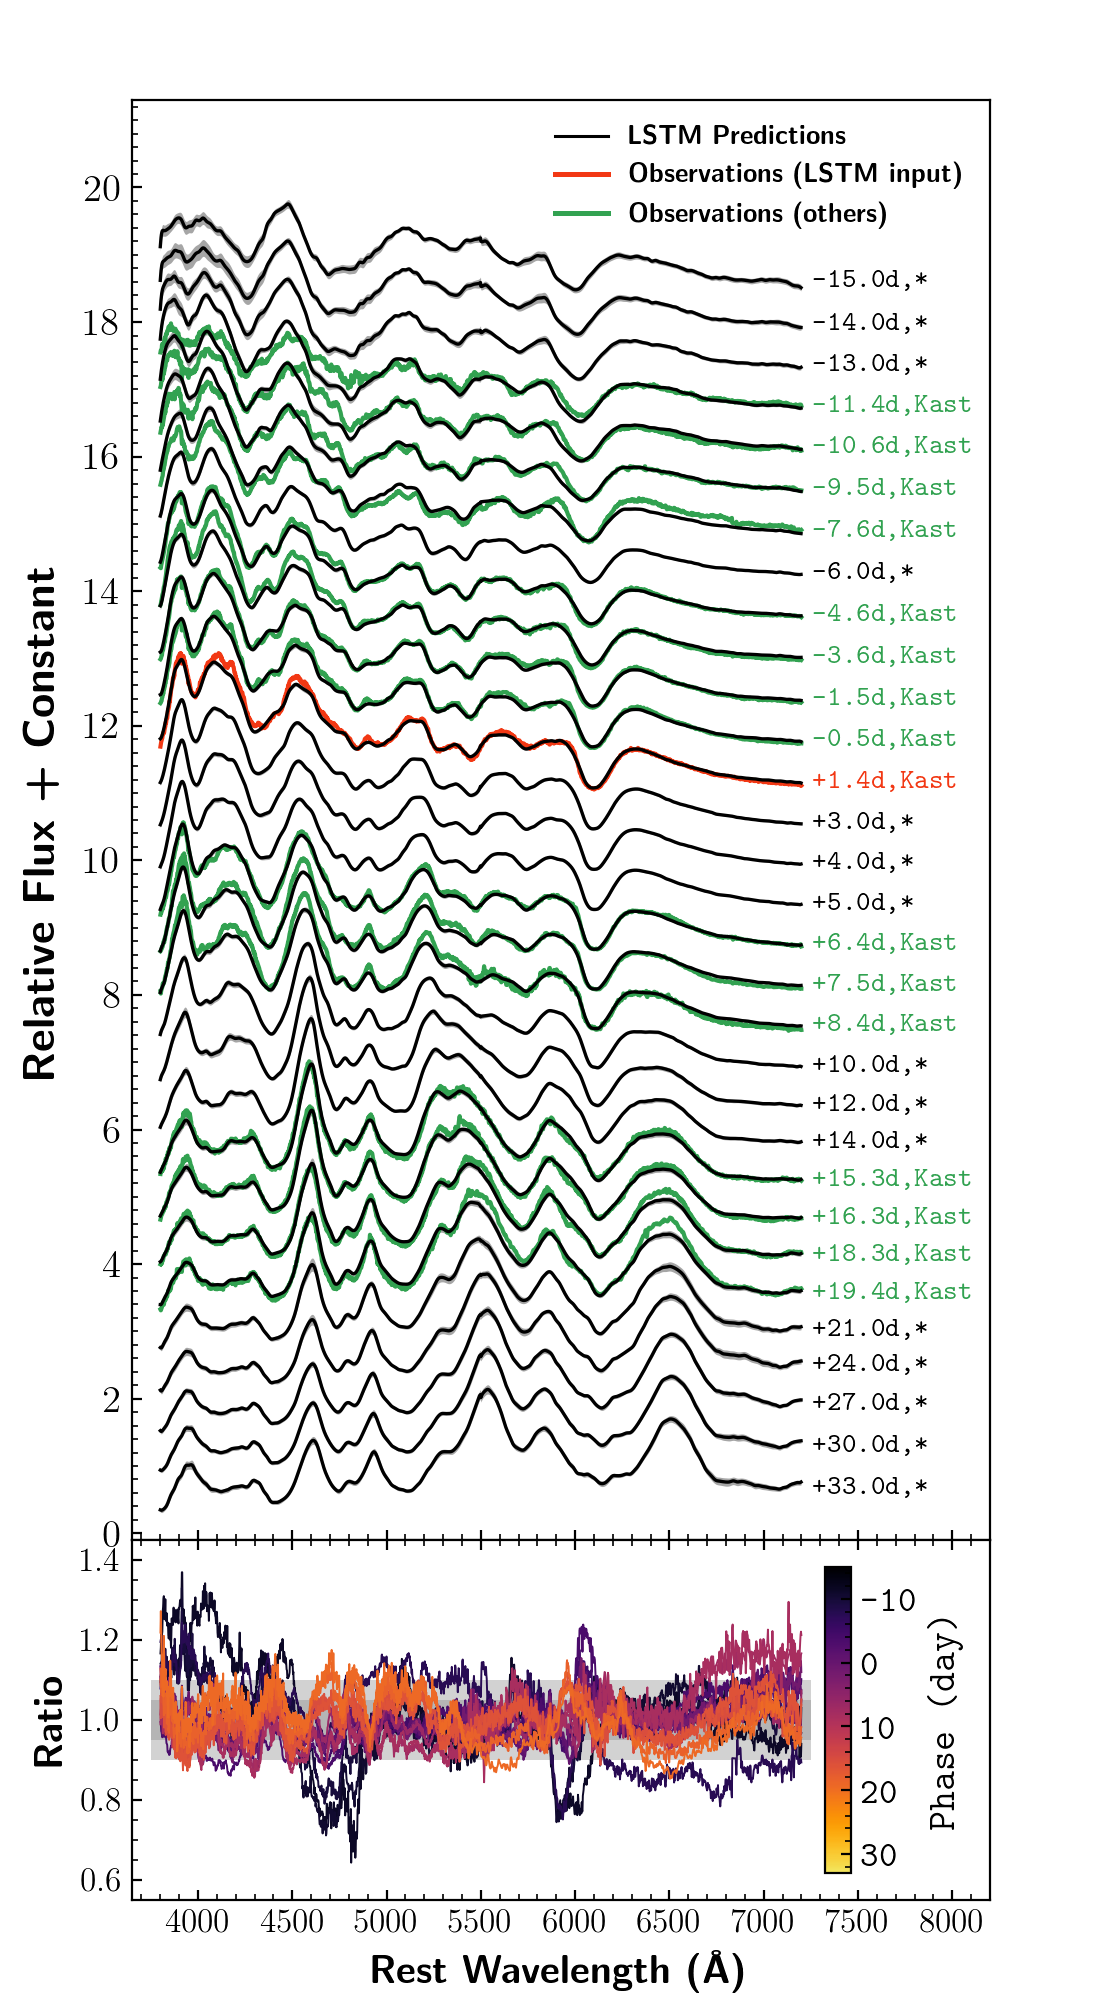

In [22]:
%matplotlib nbagg
fig = plt.figure(figsize=(5.5, 10))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig.subplots_adjust(hspace=0.0, wspace=0.0, left=0.12, right=0.9, bottom=0.05, top=0.95)

gs = gridspec.GridSpec(10, 1)
axU = plt.subplot(gs[:8, 0])
axL = plt.subplot(gs[8:, 0])

offset = 0.0
for idx in np.arange(len(PHASE_PLOT))[::-1]:
    phase = PHASE_PLOT[idx]
    item = PLOT_DICT[phase]
    
    Wlstm, Flstm, eFlstm = item['LSTM:wavelength'], item['LSTM:flux'], item['LSTM:fluxerr']
    axU.plot(Wlstm, offset+Flstm, color='black', linewidth=1.2, alpha=1.0, zorder=2)
    axU.fill_between(Wlstm, Flstm-2*eFlstm+offset, Flstm+2*eFlstm+offset, \
        color='gray', alpha=0.7, zorder=1, linewidth=0)  # 2-sigma uncertainty
    
    if 'OBS:wavelength' in item:
        Wobs, Fobs = item['OBS:wavelength'], item['OBS:flux']
        side_text = '%.1fd' %phase
        if phase > 0: side_text = '+%.1fd' %phase
        side_text = '%s,Kast' %side_text
        
        level = np.median(Flstm[-100:])-0.1
        if phase in [phase_in1, phase_in2]:
            axU.plot(Wobs, offset+Fobs, color='#F23814', linewidth=1.5, alpha=1.0, zorder=1)
            axU.annotate(r'\texttt{%s}' %side_text, xy=(7260, level+offset), fontsize=10.0, color='#F23814')
        else:
            axU.plot(Wobs, offset+Fobs, color='#32A251', linewidth=1.5, alpha=1.0, zorder=1)
            axU.annotate(r'\texttt{%s}' %side_text, xy=(7260, level+offset), fontsize=10.0, color='#32A251')
    else:
        side_text = '%.1fd,*' %phase
        if phase > 0: side_text = '+%.1fd,*' %phase
        level = np.median(Flstm[-100:])-0.1
        axU.annotate(r'\texttt{%s}' %side_text, xy=(7260, level+offset), fontsize=10.0, color='black')
    offset += 0.6

axU.plot([10000], [0.0], '-', color='black', linewidth=1.1, alpha=1.0, zorder=3, label=r'\textbf{LSTM Predictions}')
axU.plot([10000], [0.0], '-', color='#F23814', linewidth=1.8, alpha=1.0, zorder=2, label=r'\textbf{Observations (LSTM input)}')
axU.plot([10000], [0.0], '-', color='#32A251', linewidth=1.8, alpha=1.0, zorder=2, label=r'\textbf{Observations (others)}')
axU.legend(borderpad=0.5, frameon=False, fontsize=9.5) 

#axU.set_xlabel(r'\textbf{Rest Wavelength (\AA)}', fontsize=16)
axU.set_ylabel(r'\textbf{Relative Flux + Constant}', fontsize=16, labelpad=8)
axU.set_xlim(3650, 8200)
axU.set_ylim(-0.1, 21.3)

axU.xaxis.set_minor_locator(MultipleLocator(100))
axU.xaxis.set_major_locator(MultipleLocator(500))
axU.yaxis.set_minor_locator(MultipleLocator(0.2))
axU.yaxis.set_major_locator(MultipleLocator(2.0))

axU.tick_params(which='both', top=False, bottom=True, left=True, right=False, 
    labelleft=True, labelright=False, labelbottom=False, labeltop=False)

#plt.setp(axU.get_xticklabels(), fontsize=14)
plt.setp(axU.get_yticklabels(), fontsize=14)

for phase in PHASE_PLOT:
    item = PLOT_DICT[phase]
    if 'OBS:wavelength' in item:
        Wlstm, Flstm = item['LSTM:wavelength'], item['LSTM:flux']
        Wobs, Fobs = item['OBS:wavelength'], item['OBS:flux']
        # ad. hoc: matching the wavelength resolution
        xmodel = interp1d(Wlstm, Flstm, fill_value='extrapolate')
        Ratio = xmodel(Wobs) / Fobs
        co = cmap_inf((phase+15.0)/48.0)
        axL.plot(Wobs, Ratio, '-', color=co, linewidth=0.7, alpha=1.0)

axL.fill_between([3750, 7250], [0.95, 0.95], [1.05, 1.05], color='gray', alpha=0.35, linewidth=0)    
axL.fill_between([3750, 7250], [0.9, 0.9], [1.1, 1.1], color='gray', alpha=0.35, linewidth=0)    
axL.set_xlabel(r'\textbf{Rest Wavelength (\AA)}', fontsize=14)
axL.set_ylabel(r'\textbf{Ratio}', fontsize=14)
axL.set_xlim(3650, 8200)
axL.set_ylim(0.55, 1.45)

axL.xaxis.set_minor_locator(MultipleLocator(100))
axL.xaxis.set_major_locator(MultipleLocator(500))
axL.yaxis.set_minor_locator(MultipleLocator(0.05))
axL.yaxis.set_major_locator(MultipleLocator(0.2))

axL.tick_params(which='both', top=True, bottom=True, left=True, right=False, 
    labelleft=True, labelright=False, labelbottom=True, labeltop=False)

plt.setp(axL.get_xticklabels(), fontsize=12)
plt.setp(axL.get_yticklabels(), fontsize=12)

_cax = inset_axes(axL, width="3%", height="85%", loc=5, borderpad=5) 
_cb = fig.colorbar(scalarMap_p, cax=_cax, orientation='vertical')

_Gt = [-10, 0, 10, 20, 30]   # USER-DEFINED
_clab = [r'\textbf{\texttt{%d}}' %x for x in _Gt]

_cb.set_ticks(_Gt)
_cb.ax.set_yticklabels(_clab, fontsize=13)
_cb.ax.set_ylabel(r'\textbf{\texttt{Phase (day)}}', fontsize=14)
_cb.ax.minorticks_on()
_cb.ax.invert_yaxis()

plt.show()
